In [1]:
try:
    from pyspark import SparkContext, SparkConf
    from pyspark.sql import SparkSession
except ImportError as e:
    print('<<<<<!!!!! Please restart your kernel after installing Apache Spark !!!!!>>>>>')
sc = SparkContext.getOrCreate(SparkConf().setMaster("local[*]"))

spark = SparkSession \
    .builder \
    .getOrCreate()

In [2]:
from pyspark.sql.types import *
from pyspark.sql import SQLContext
sqlCtx = SQLContext(sc)

# Auxiliar functions
def equivalent_type(f):
    if f == 'datetime64[ns]': return TimestampType()
    elif f == 'int64': return LongType()
    elif f == 'int32': return IntegerType()
    elif f == 'float64': return FloatType()
    else: return StringType()

def define_structure(string, format_type):
    try: typo = equivalent_type(format_type)
    except: typo = StringType()
    return StructField(string, typo)

# Given pandas dataframe, it will return a spark's dataframe.
def pandas_to_spark(pandas_df):
    columns = list(pandas_df.columns)
    types = list(pandas_df.dtypes)
    struct_list = []
    for column, typo in zip(columns, types): 
      struct_list.append(define_structure(column, typo))
    p_schema = StructType(struct_list)
    return sqlCtx.createDataFrame(pandas_df, p_schema)

In [12]:
from pyspark.ml.clustering import BisectingKMeans
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler, Normalizer
from pyspark.ml.linalg import Vectors
from pyspark.ml import Pipeline

import pandas as pd

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.datasets import make_blobs

plt.figure(figsize=(12, 12))

n_samples = 5000
random_state = 42
n_clusters = 7
X, y = make_blobs(n_samples=n_samples, centers=n_clusters)

df = pd.DataFrame(X, columns=['A', 'B'])
df_spark = pandas_to_spark(df)

n_clusters

df = pd.DataFrame(X, columns=['A', 'B'])
df_spark = pandas_to_spark(df)

df_spark.columns

vectorAssembler = VectorAssembler(inputCols=df_spark.columns,
                                  outputCol="features")
normalizer = Normalizer(inputCol="features", outputCol="features_norm", p=1.0)

df_spark = vectorAssembler.transform(df_spark)

algorithm = BisectingKMeans(k=n_clusters, distanceMeasure='euclidean', maxIter=100, minDivisibleClusterSize=1, seed=None)

model = algorithm.fit(df_spark)

predictions = model.transform(df_spark)

<Figure size 864x864 with 0 Axes>

Text(0.5, 1.0, 'Blobs')

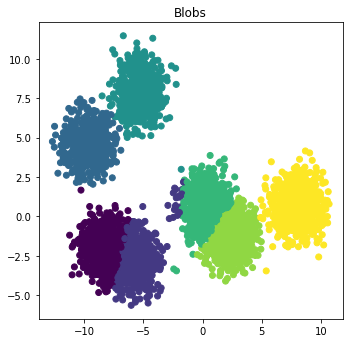

In [13]:
labels = predictions.select('prediction').toPandas()['prediction']

plt.figure(figsize=(12, 12))
plt.subplot(221)
plt.scatter(X[:, 0], X[:, 1], c=labels)
plt.title("Blobs")

In [82]:
from pyspark.sql import Row
import math
from graphframes import *
from itertools import combinations


def __distance_from_pivot(pivot, dist, epsilon, operations):
    def distance(x):
        pivot_dist = dist(x.value, pivot)
        if operations is not None:
            operations.add()
        partition_index = math.floor(pivot_dist / epsilon)
        rows = [Row(id=x.id, value=x.value, pivot_dist=dist(x.value, pivot))]
        out = [(partition_index, rows),
               (partition_index + 1, rows)]
        return out
    return distance


def __scan(epsilon, dist, operations):
    def scan(x):
        # out dictionary would have point id as key and a set of point ids who are within epsilon distance to
        # key point id. value is basically its neighbors
        out = {}
        # 0th index of x is partition_index
        # 1st index of x is data points
        partition_data = x[1]
        partition_len = len(partition_data)
        for i in range(partition_len):
            for j in range(i + 1, partition_len):
                if operations is not None:
                    operations.add()
                if dist(partition_data[i].value, partition_data[j].value) < epsilon:
                    # both i and j are within epsilon distance to each other
                    if partition_data[i].id in out:
                        out[partition_data[i].id].add(partition_data[j].id)
                    else:
                        out[partition_data[i].id] = set([partition_data[j].id])
                    if partition_data[j].id in out:
                        out[partition_data[j].id].add(partition_data[i].id)
                    else:
                        out[partition_data[j].id] = set([partition_data[i].id])
        # returns point and its neighbor as tuple
        return [Row(item[0], item[1]) for item in out.items()]

    return scan


def __label(min_pts):
    def label(x):
        if len(x[1]) + 1 >= min_pts:
            # use id as cluster label
            cluster_label = x[0]
            # return True for core point
            out = [(x[0], [(cluster_label, True)])]
            for idx in x[1]:
                # return False for base point
                out.append((idx, [(cluster_label, False)]))
            return out
        return []

    return label


def __combine_labels(x):
    # 0th element is the id of point
    # 1st element is the list of tuples with cluster and core point label
    point = x[0]
    core_point = False
    cluster_labels = x[1]
    clusters = []
    for (label, point_type) in cluster_labels:
        if point_type is True:
            core_point = True
        clusters.append(label)
    # if core point keep all cluster otherwise only one
    return point, clusters if core_point is True else [clusters[0]], core_point


def process(spark, df, epsilon, min_pts, dist, dim, checkpoint_dir, operations=None):
    """
    Process given dataframe with DBSCAN parameters
    :param spark: spark session
    :param df: input data frame where each row has id and value keys
    :param epsilon: DBSCAN parameter for distance
    :param min_pts: DBSCAN parameter for minimum points to define core point
    :param dist: method to calculate distance. Only distance metric is supported.
    :param dim: number of dimension of input data
    :param checkpoint_dir: checkpoint path as required by Graphframe
    :param operations: class for managing accumulator to calculate number of distance operations
    :return: A dataframe of point id, cluster component and boolean indicator for core point
    """
    zero = [0] * dim
    combine_cluster_rdd = df.rdd.\
        flatMap(__distance_from_pivot(zero, dist, epsilon, operations)). \
        reduceByKey(lambda x, y: x + y).\
        flatMap(__scan(epsilon, dist, operations)). \
        reduceByKey(lambda x, y: x.union(y)).\
        flatMap(__label(min_pts)).\
        reduceByKey(lambda x, y: x + y).map(__combine_labels).cache()
    id_cluster_rdd = combine_cluster_rdd.\
        map(lambda x: Row(point=x[0], cluster_label=x[1][0], core_point=x[2]))
    try:
        id_cluster_df = id_cluster_rdd.toDF()
        vertices = combine_cluster_rdd.\
            flatMap(lambda x: [Row(id=item) for item in x[1]]).toDF().distinct()
        edges = combine_cluster_rdd. \
            flatMap(lambda x: [Row(src=item[0], dst=item[1])
                               for item in combinations(x[1], 2)]). \
            toDF().distinct()
        spark.sparkContext.setCheckpointDir(checkpoint_dir)
        g = GraphFrame(vertices, edges)
        connected_df = g.connectedComponents()
        id_cluster_df = id_cluster_df.\
            join(connected_df, connected_df.id == id_cluster_df.cluster_label). \
            select("point", "component", "core_point")
        return id_cluster_df
    except ValueError:
        return None

In [62]:
from sklearn.cluster import DBSCAN
centers = [[1, 1], [-1, -1], [1, -1]]
# with following data operations with sklearn dbscan 750*749/2 = 280875 for spark  149716(.2) 217624(0.3)
X, labels_true = make_blobs(n_samples=750, centers=centers, cluster_std=0.4, random_state=5)
db = DBSCAN(eps=0.2, min_samples=10).fit(X)
labels = db.labels_

In [63]:
from pyspark.sql import types as T, SparkSession
from scipy.spatial import distance
from graphframes import *

def dist(x, y):
    return distance.euclidean(x, y)

n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)
labels_spark = np.zeros_like(db.labels_)
labels_spark[:] = -1

data = [(i, [float(item) for item in X[i]]) for i in range(X.shape[0])]
schema = T.StructType([T.StructField("id", T.IntegerType(), False),
                       T.StructField("value", T.ArrayType(T.FloatType()), False)])
df = spark.createDataFrame(data, schema=schema)
result = process(spark, df, .2, 10, dist, 2, "checkpoint")
# out = df_clusters.distinct().collect()

In [68]:
vertices, edges = result
g = GraphFrame(vertices, edges)

Py4JJavaError: An error occurred while calling o1540.loadClass.
: java.lang.ClassNotFoundException: org.graphframes.GraphFramePythonAPI
	at java.base/java.net.URLClassLoader.findClass(URLClassLoader.java:471)
	at java.base/java.lang.ClassLoader.loadClass(ClassLoader.java:588)
	at java.base/java.lang.ClassLoader.loadClass(ClassLoader.java:521)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:566)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:238)
	at java.base/java.lang.Thread.run(Thread.java:834)


In [53]:
dim=2
epsilon=0.2
operations=None
min_pts=10
zero = [0] * dim
combine_cluster_rdd = df.rdd.\
    flatMap(__distance_from_pivot(zero, dist, epsilon, operations)). \
    reduceByKey(lambda x, y: x + y).\
    flatMap(__scan(epsilon, dist, operations)). \
    reduceByKey(lambda x, y: x.union(y)).\
    flatMap(__label(min_pts)).\
    reduceByKey(lambda x, y: x + y).map(__combine_labels).cache()

In [54]:
combine_cluster_rdd.collect()

[(144,
  [144,
   616,
   16,
   224,
   720,
   729,
   481,
   586,
   506,
   59,
   195,
   347,
   627,
   75,
   36,
   212,
   652,
   485,
   573,
   589,
   629,
   405,
   126,
   486,
   7,
   599,
   287],
  True),
 (16,
  [144,
   16,
   160,
   224,
   105,
   369,
   513,
   609,
   481,
   586,
   282,
   434,
   618,
   418,
   506,
   195,
   347,
   20,
   36,
   212,
   485,
   101,
   405,
   421,
   605,
   342,
   6,
   494,
   542,
   7,
   599,
   255,
   287],
  True),
 (720,
  [144,
   504,
   720,
   729,
   481,
   586,
   506,
   59,
   195,
   627,
   51,
   75,
   468,
   36,
   652,
   573,
   7,
   599,
   375],
  True),
 (224,
  [144,
   16,
   160,
   224,
   369,
   513,
   609,
   481,
   586,
   306,
   394,
   282,
   434,
   618,
   506,
   59,
   195,
   347,
   555,
   20,
   36,
   212,
   652,
   101,
   405,
   421,
   6,
   22,
   542,
   7,
   599,
   287],
  True),
 (616,
  [144,
   456,
   616,
   8,
   504,
   568,
   217,
   729,
   5

In [58]:
graphframes.__version__

NameError: name 'graphframes' is not defined

In [60]:
GraphFrame

graphframes.graphframe.GraphFrame

In [70]:
import pyspark
pyspark.__version__

'3.0.0'

In [76]:
import graphframes
graphframes

<module 'graphframes' from 'C:\\Users\\Vladimir\\anaconda3\\envs\\spark_env\\lib\\site-packages\\graphframes\\__init__.py'>

In [85]:
from sklearn.datasets import make_blobs
from pyspark.sql import types as T, SparkSession
from scipy.spatial import distance

spark = SparkSession \
        .builder \
        .appName("DBSCAN") \
        .config("spark.jars.packages", "graphframes:graphframes:0.8.0-spark3.0-s_2.12") \
        .config('spark.driver.host', '127.0.0.1') \
        .getOrCreate()

X, labels_true = make_blobs(n_samples=750, centers=centers, cluster_std=0.4, random_state=5)
data = [(i, [float(item) for item in X[i]]) for i in range(X.shape[0])]
schema = T.StructType([T.StructField("id", T.IntegerType(), False),
                               T.StructField("value", T.ArrayType(T.FloatType()), False)])
df = spark.createDataFrame(data, schema=schema)
df_clusters = process(spark, df, .2, 10, distance.euclidean, 2, "checkpoint")

Py4JJavaError: An error occurred while calling o1995.loadClass.
: java.lang.ClassNotFoundException: org.graphframes.GraphFramePythonAPI
	at java.base/java.net.URLClassLoader.findClass(URLClassLoader.java:471)
	at java.base/java.lang.ClassLoader.loadClass(ClassLoader.java:588)
	at java.base/java.lang.ClassLoader.loadClass(ClassLoader.java:521)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:566)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:238)
	at java.base/java.lang.Thread.run(Thread.java:834)


In [81]:
df_clusters[0].show()

+---+
| id|
+---+
| 26|
|474|
| 29|
|418|
| 65|
|558|
|191|
|541|
|222|
|293|
|730|
|720|
|278|
|243|
|705|
|367|
| 54|
| 19|
|296|
|287|
+---+
only showing top 20 rows



In [87]:
v = sqlCtx.createDataFrame([
  ("a", "Alice", 34),
  ("b", "Bob", 36),
  ("c", "Charlie", 30),
  ("d", "David", 29),
  ("e", "Esther", 32),
  ("f", "Fanny", 36),
  ("g", "Gabby", 60)
], ["id", "name", "age"])
# Edge DataFrame
e = sqlCtx.createDataFrame([
  ("a", "b", "friend"),
  ("b", "c", "follow"),
  ("c", "b", "follow"),
  ("f", "c", "follow"),
  ("e", "f", "follow"),
  ("e", "d", "friend"),
  ("d", "a", "friend"),
  ("a", "e", "friend")
], ["src", "dst", "relationship"])
# Create a GraphFrame
g = GraphFrame(v, e)

Py4JJavaError: An error occurred while calling o2028.loadClass.
: java.lang.ClassNotFoundException: org.graphframes.GraphFramePythonAPI
	at java.base/java.net.URLClassLoader.findClass(URLClassLoader.java:471)
	at java.base/java.lang.ClassLoader.loadClass(ClassLoader.java:588)
	at java.base/java.lang.ClassLoader.loadClass(ClassLoader.java:521)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:566)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:238)
	at java.base/java.lang.Thread.run(Thread.java:834)


graphframes.graphframe.GraphFrame